cannon
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import tensorflow as tf
import keras

In [2]:
# a spherical target gets a position somewhere in 3d. The cannon at (0,0,0) fires a shell at a given speed,\
# rotation, and angle.

In [7]:
pi = np.pi

#simulates a ballistic trajectory and returns the smallest distance to the target position
def simulate_trajectory_distance(speed, azi, pitch, target, origin = np.array([0.,0.,0.]), timestep = 0.1, g = -10.):
    #get cartesian velocity from spherical coordinates
    velocity = speed*np.array([
        np.cos(azi)*np.cos(pitch),
        np.sin(azi)*np.cos(pitch),
        np.sin(pitch)
    ])
#     print(f'Starting velocity {velocity}.')
    #make acceleration vector
    acc = np.array([0.,0., g])
    #record origin and first position after 1 timestep
    history = [origin, origin+ velocity*timestep + (1/2)*acc*timestep**2]
    position = history[-1]
#     print(history)
    #record distances
    distances = [np.linalg.norm(target - origin), np.linalg.norm(target - position)]
    #while the ball is above the ground, timestep to change position
    while position[2] >= 0:
#         print(history[-1])
        position = 2*history[-1] - history[-2] + acc*(timestep**2)
        distances.append(np.linalg.norm(target - position))
        history.append(position)
    return np.array(distances).min()
    

In [9]:
distance = simulate_trajectory_distance(100, 0, pi/3, np.array([100,200,300]))

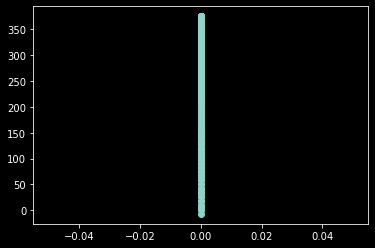

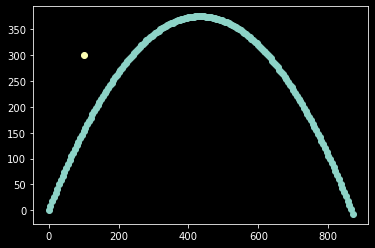

In [5]:
plt.scatter(history[:,1],history[:,2])
plt.show()
plt.scatter(history[:,0],history[:,2])
plt.scatter([[100]],[[300]])
plt.show()

In [51]:
# %%time

seed = 2022
rng = np.random.default_rng(seed)

eps = np.finfo(np.float32).eps.item()

gamma = 0.99
rounds_per_load = 5
minimum_acceptable_score = 500
scores_to_average = 10
max_speed = 100 #m/s
field_size = 2000 #m

hit_distance = 10 #10 cm radius of target
miss_penalty = 500 #add this number of meters to distance as a penalty for missing.

num_inputs = 3 #targetx,y,z
num_outputs = 3 #speed*max_speed, azimuth/(2pi), pitch/(pi)
num_hidden = 32

#make model
inputs = keras.layers.Input(shape = (num_inputs,))
dense_1 = keras.layers.Dense(num_hidden, activation = 'relu')(inputs)
outputs = keras.layers.Dense(num_outputs)(dense_1)
model = keras.Model(inputs = inputs, outputs = outputs)

#make optimizer
optimizer = keras.optimizers.Adam(learning_rate = 0.01)

avg_recent_score = 0
all_scores = [0]
total_loss = tf.constant(0.)

model.trainable_variables[1] = tf.convert_to_tensor(np.full(32,1))
#train until performance is good enough
while avg_recent_score < minimum_acceptable_score:
    with tf.GradientTape() as tape:
#         tape.watch(total_loss)
#         tape.watch(model.trainable_variables)
        command_history = []
        loss_history = []
        #reload the cannon and shoot all the shots
        for shot in range(rounds_per_load):
            #place a random target in the block, and make sure it's above the ground.
            target = field_size*rng.random(3) - field_size/2
            target[2] = abs(target[2])
            target = tf.convert_to_tensor(target)
            target = tf.expand_dims(target, 0)
            
            command = model(target)
            speed, azi, pitch = command[0]
#             command_history.append([speed, azi, pitch])
            speed = np.float32(speed*max_speed)
            azi = np.float32(azi*2*pi)
            pitch =  np.float32(pitch*pi)
            
            loss = simulate_trajectory_distance(speed, azi, pitch, target, timestep=0.5)
            if distance > hit_distance:
                loss += miss_penalty
            loss_history.append(loss)
            
        total_loss = tf.constant(sum(loss_history))
        grads = tape.gradient(total_loss, model.trainable_variables )
        if grads == [None, None,None, None]:
            grads = [[0.,0.,0.,0.]]
        print('got to optimizing')
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        all_scores.append(total_loss)
#         command_history.clear()
        loss_history.clear()
        
        avg_recent_score = np.mean(all_scores[-scores_to_average:])
        if len(all_scores[:-2])%1:
            print(f'Finished with trial {len(all_scores[:-2])}')

got to optimizing


InvalidArgumentError: var and grad do not have the same shape[3,32] [4] [Op:ResourceApplyAdam]

In [52]:
grads

[[0.0, 0.0, 0.0, 0.0]]